## Report

##### Overview|
A Deep CNN model was implemented for multiclass classification of an unknown image dataset.

##### 1. Descriptive Analysis
- Plotted the RGB images for a random sample of the dataset
- Printed various statistics using pandas, such as value_counts, data percentiles

##### 2. Detection and Handling of Missing Values
- Dropped rows with NaN labels as we don't know how to train with unknown labels
- Perhaps can re-use for pseudo-labeling but would be costly
- Replaced NaN values with the mean of their 3x3 kernel using torch conv2d function

##### 3. Detection and Handling of Outliers
- Saw many outliers below 0 and above 255 by checking summary statistics
- Handled outliers by clipping the RGB values to the range [0,255]
- Did not remove any rows as the provided dataset is quite small and the model would have too little data to work with

##### 4. Detection and Handling of Class Imbalance 
- The provided dataset is already quite small with n=2620 after handling NaN values
- Using k-fold cross validation, the precision and recall metrics are relatively balanced
- Our model is not not affected by class imbalance even without any oversampling or undersampling techniques

##### 5. Understanding Relationship Between Variables
- Correlation matrix was plotted which shows that the vast majority of variables were not correlated
- No pairs of features had above 0.99 correlation

##### 6. Data Visualization
- Image data was visualized using imshow()
- Statiscal graphs were plotted using seaborn
    - Frequency (histogram) of pixel values per color channel

##### 7. General Preprocessing
- No categorical variables are present
- Min-max scaling was performed by dividing all RGB values by 255 to put them in the range [0,1]
- CNN also has BatchNorm layers for normalization

##### 8. Feature Selection
- PCA is performed with explained variance cutoff at 0.98 (which corresponds to 199 features in channel 0)
- PCA only done on channel 0 as the explained variance graph is almost perfectly straight for channels 1 and 2, meaning every feature in those channels is almost equally important

##### 9. Feature Engineering
- Data augmentation was performed using torchvision transforms library
- Transformations like random flipping and color jitter were tested to be ineffective and severely reduced the F1 score
- Random crop and random resized crop were also ineffective and had slightly worse F1 score than without transformations
- Transformations also increased the computational complexity significantly
- Final model did not make use of transformations

##### 10. Creating Models
- The provided dataset was split into training and testing sets
- The training set was further paritioned into training and validation sets using k-fold cross validation to improve the performance estimate
- Processed dataset in batches; batch size is a hyperparamater that is tuned manually
- Trained models using GPU for fast speed. Code will still work on systems without GPU support
- Used Adam optimizer function with StepLR to dynamically reduce the learning rate by half every 15 epochs
    - SGD was also tested but performed worse
- Loss function is a custom-written differentiable macro F1 loss
    - Binary cross entropy loss function was tested but performed worse
- Loss has many spikes near the end of training, so I kept track of the loss in each epoch and used the best model state with the lowest loss

- Tested multiple different models: SimpleNN, SimpleCNN, DeepCNN, DeepCNN2
    - SimpleNN is a simple NN with a few linear layers and relu activation
    - SimpleCNN is a CNN with 2 conv2d layers and relu activation
    - DeepCNN is a CNN with large output channel conv2d layers and relu activation
    - DeepCNN2 is improved upon DeepCNN, with 3 conv2d layers, 3 fully connected layers and PReLU activation
    - Final layer is Softmax to obtain the probabilities for each class, and for compatibility with the custom loss function
    - Dropout layers introduced regularization to prevent overfitting
    - BatchNorm layers improved speed of convergence

##### 11. Model Evaluation
- DeepCNN2 had a macro f1, macro precision and macro recall score of 0.83, 0.79 and 0.87 respectively on the testing set
- Confusion matrix was plotted; the majority of misclassifications come from class 1 with 33 correct classifications and 18 incorrect classifications
- Overall, the model is still quite effective

##### 11. Hyperparameter Tuning
- Manual hyperparameter tuning was performed by searching the following hyperparameters:
    - no. of hidden layers (3-6 Conv layers, 3-6 FC layers)
    - no. of neurons per layer (8/16/32/64/128)
    - no. of output channels in each conv2d layer (8/16/32/64/128)
    - activation function (relu/prelu)
    - p value in dropout layers (0.1-0.8)
    - batch size (32/64/128)

##### Conclusion
- Deep CNN can capture complicated patterns in image data, even if humans can't perceive said data

---

## Import Packages

In [1]:
import pandas as pd
import os
import numpy as np
np.set_printoptions(precision=2, linewidth=200, suppress=True)

import gc
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
plt.style.use(['dark_background'])

## Load Dataset

The dataset `data/images.npy` is of size $(N, C, H, W)$, where $N$, $C$, $H$, and $W$ correspond to the number of data, image channels, image width, and image height, respectively.

### Load Image Data

In [2]:
with open('data.npy', 'rb') as f:
    data = np.load(f, allow_pickle=True).item()
    images = data['image']
    labels = data['label']

## Data Exploration & Preparation

### 1. Descriptive Analysis

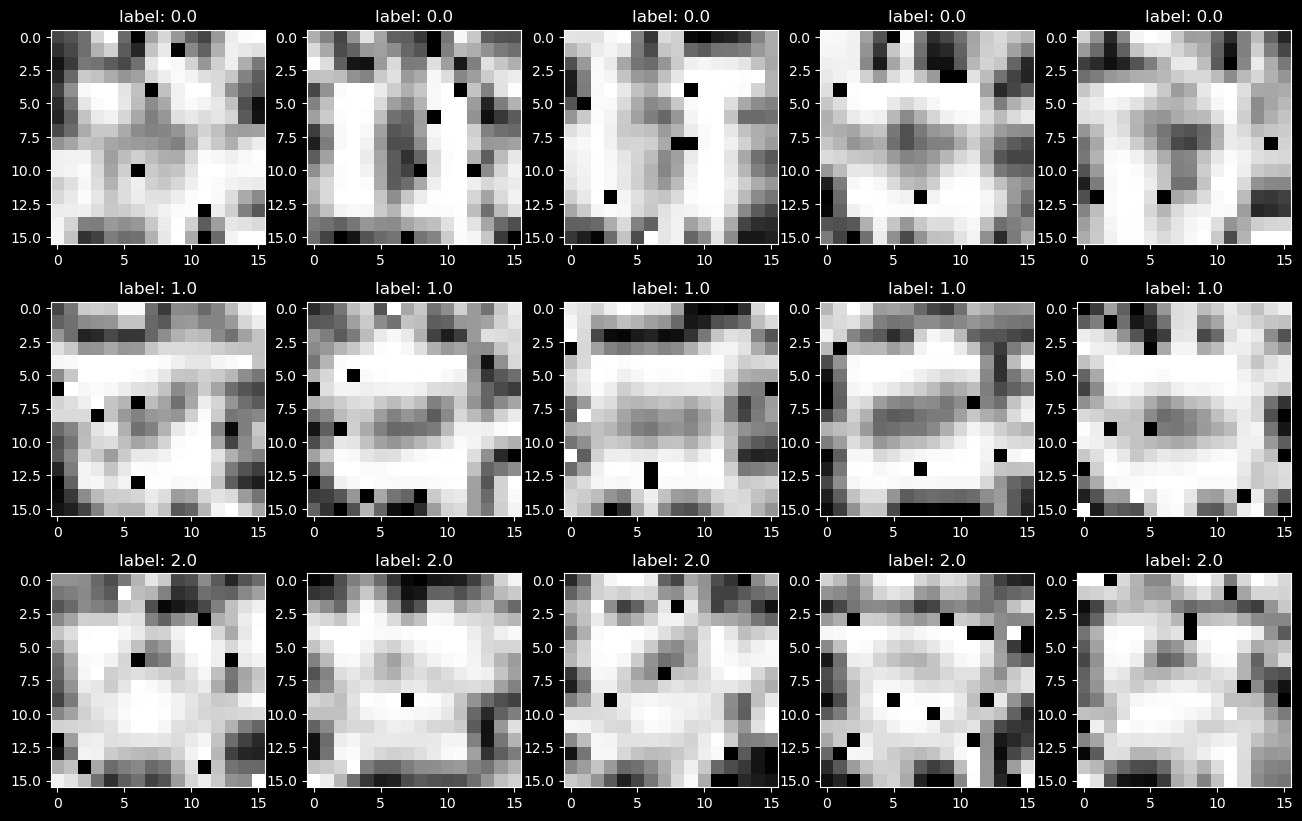

In [3]:
def show_images(images, labels, n_row=3, n_col=5, figsize=[16,10]):
    # credit to the mock exam utils.py
    _, axs = plt.subplots(n_row, n_col, figsize=figsize)
    axs = axs.flatten()

#     idx = np.random.choice(images.shape[0], size=n_row*n_col, replace=False)
    idx = np.random.choice(np.nonzero(labels == 0)[0], size=n_col, replace=False)
    idx = np.append(idx, np.random.choice(np.nonzero(labels == 1)[0], size=n_col, replace=False))
    idx = np.append(idx, np.random.choice(np.nonzero(labels == 2)[0], size=n_col, replace=False))
    
    for img, title, ax in zip(images[idx], labels[idx], axs):
        img = np.transpose(img, (1, 2, 0))
        img = np.clip(img, 0, 255)
#         img = np.nan_to_num(img, 0)
        ax.imshow(img, cmap='Grays')
        ax.set_title(f"label: {title}")
    plt.show()

# show_images(images, labels)
images = images[:, [0], :, :] # drop channels 1-2
show_images(images, labels)

In [4]:
def check_imbalance(labels):
    return pd.Series(labels).value_counts(dropna=False)
check_imbalance(labels)

0.0    2392
NaN     291
1.0     203
2.0      25
Name: count, dtype: int64

In [5]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.Series(images.reshape(-1)).describe(percentiles=[0.01,0.1,0.25,0.50,0.75,0.90,0.99])
# clearly shows that image is RGB data in range [0,255]
# some values are not integers. should decide whether to cast as int or leave as those values

count   737843.00
mean          NaN
std           NaN
min     -10000.00
1%           0.00
10%          7.00
25%         41.00
50%         91.00
75%        143.00
90%        192.00
99%        255.00
max      10000.00
dtype: float64

In [6]:
pd.Series(images.reshape(-1)).value_counts(dropna=False)

0.00        39737
NaN          7373
1.00         6012
255.00       5503
92.00        4252
            ...  
-3834.00        1
-1394.00        1
-1561.00        1
2174.00         1
-139.00         1
Name: count, Length: 6053, dtype: int64

In [7]:
images[:10]

array([[[[   36.,    nan,    20., ...,   190.,   170.,   162.],
         [   81.,    60.,    30., ...,   190.,   180.,   177.],
         [  160.,   116.,    44., ...,   185.,   198.,   204.],
         ...,
         [   32.,    19.,     1., ...,   172.,   191.,   196.],
         [   96.,    72.,    32., ...,   226.,   221.,   210.],
         [  138.,   106.,    52., ...,   255.,   239.,   220.]]],


       [[[  253.,   240.,   205., ...,   241.,    81.,     0.],
         [  242.,   221.,   177., ...,   216.,    68.,     0.],
         [  217.,   181.,   122., ...,   175.,    53.,     0.],
         ...,
         [    4.,     8.,    14., ...,   182.,   202.,   208.],
         [   50.,    92.,   161., ...,   175.,   173.,    nan],
         [   77.,   140.,   244., ...,   166.,   153.,   146.]]],


       [[[  237.,   148.,     3., ...,   164.,    50.,     0.],
         [  188.,   153.,    94., ...,   137.,    57.,    17.],
         [  102.,   156.,   240., ...,    95.,    78.,  9024.],
    

### 2. Detection and Handling of Missing Values

In [8]:
# drop rows with nan labels
idx_to_keep = ~np.isnan(labels)
labels = labels[idx_to_keep]
images = images[idx_to_keep]

In [9]:
np.count_nonzero(np.isnan(images))

6586

### 3. Detection and Handling of Outliers

In [10]:
images.clip(0, 255, out=images)

array([[[[253., 240., 205., ..., 241.,  81.,   0.],
         [242., 221., 177., ..., 216.,  68.,   0.],
         [217., 181., 122., ..., 175.,  53.,   0.],
         ...,
         [  4.,   8.,  14., ..., 182., 202., 208.],
         [ 50.,  92., 161., ..., 175., 173.,  nan],
         [ 77., 140., 244., ..., 166., 153., 146.]]],


       [[[237., 148.,   3., ..., 164.,  50.,   0.],
         [188., 153.,  94., ..., 137.,  57.,  17.],
         [102., 156., 240., ...,  95.,  78., 255.],
         ...,
         [240.,   0.,  22., ...,  40., 116., 158.],
         [163., 140., 102., ...,  69.,  60., 255.],
         [117., 127., 147., ...,  86.,  27.,   0.]]],


       [[[237., 208., 151., ..., 218.,  67.,   0.],
         [240., 204., 134., ..., 193.,  76.,  19.],
         [235., 186.,  99., ..., 146.,  92.,  62.],
         ...,
         [255., 182.,  36., ...,  96., 141., 163.],
         [255., 195.,  84., ..., 170., 141., 120.],
         [254., 199., 111., ..., 210., 138.,  93.]]],


       ...

In [11]:
pd.Series(images.reshape(-1)).describe(percentiles=[0.01,0.1,0.25,0.50,0.75,0.90,0.99])

count   664134.00
mean          NaN
std          0.00
min          0.00
1%           0.00
10%          7.00
25%         41.00
50%         91.00
75%        143.00
90%        192.00
99%        255.00
max        255.00
dtype: float64

In [12]:
pd.Series(images.reshape(-1)).value_counts(dropna=False)

0.00      42383
255.00    11494
NaN        6586
1.00       5413
92.00      3876
          ...  
247.00      540
254.00      533
248.00      526
251.00      526
252.00      514
Name: count, Length: 257, dtype: int64

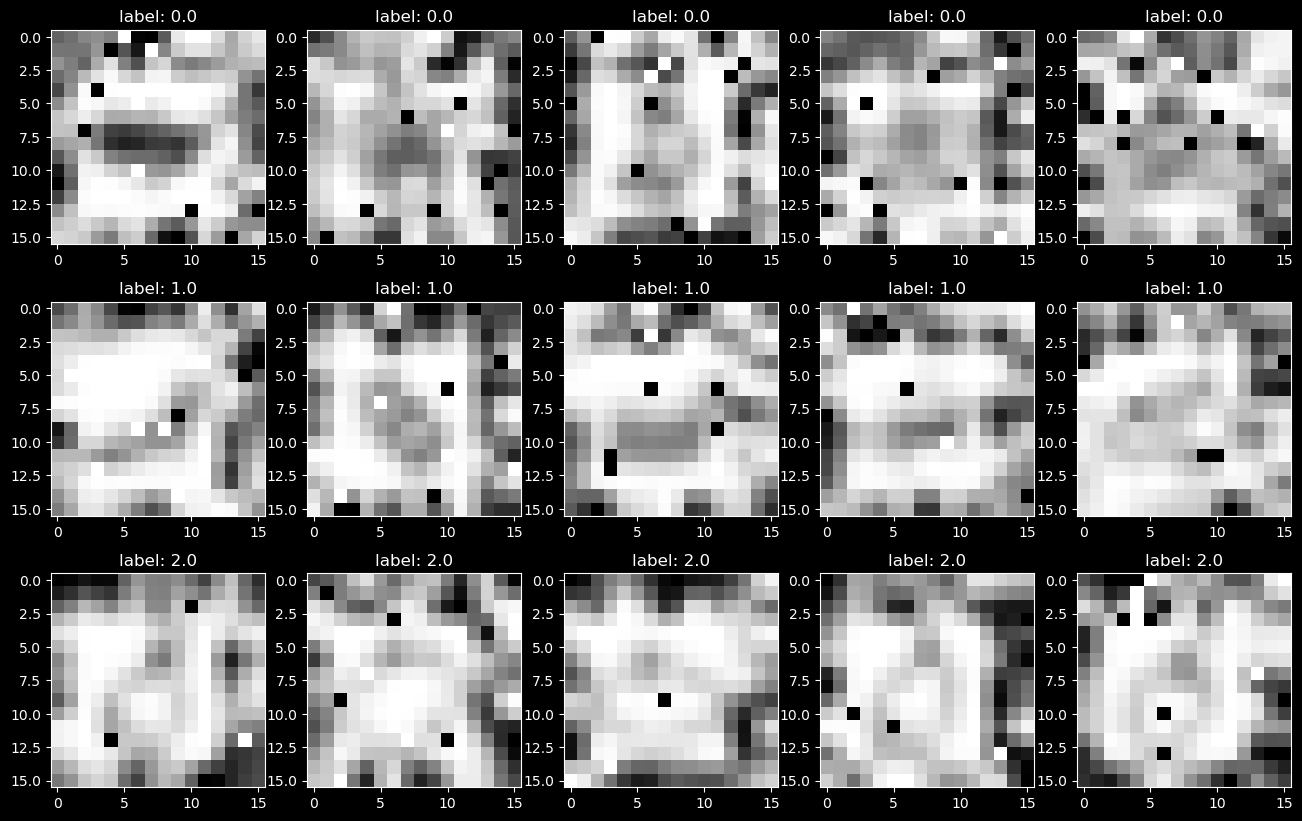

In [13]:
show_images(images, labels)

In [14]:
# convert nan values to mean of its 3x3 square
import torch
import torch.nn.functional as F
torch.set_printoptions(precision=2, sci_mode=False)

def handle_nans(images):
    N, C, H, W = images.shape
    images_tensor = torch.tensor(images, dtype=torch.float32).reshape(N*C, 1, H, W)
    nan_mask = torch.isnan(images_tensor)
    images_tensor[nan_mask] = 0

    kernel = torch.ones((1, 1, 3, 3))
    conv_result = F.conv2d(images_tensor, kernel, padding=1)

    count_nonnan = F.conv2d((~nan_mask).float(), kernel, padding=1)
    conv_result /= count_nonnan
    images_tensor[nan_mask] = conv_result[nan_mask]
    images = images_tensor.reshape(images.shape).numpy()
    return images
images = handle_nans(images)

In [15]:
np.count_nonzero(np.isnan(images))

0

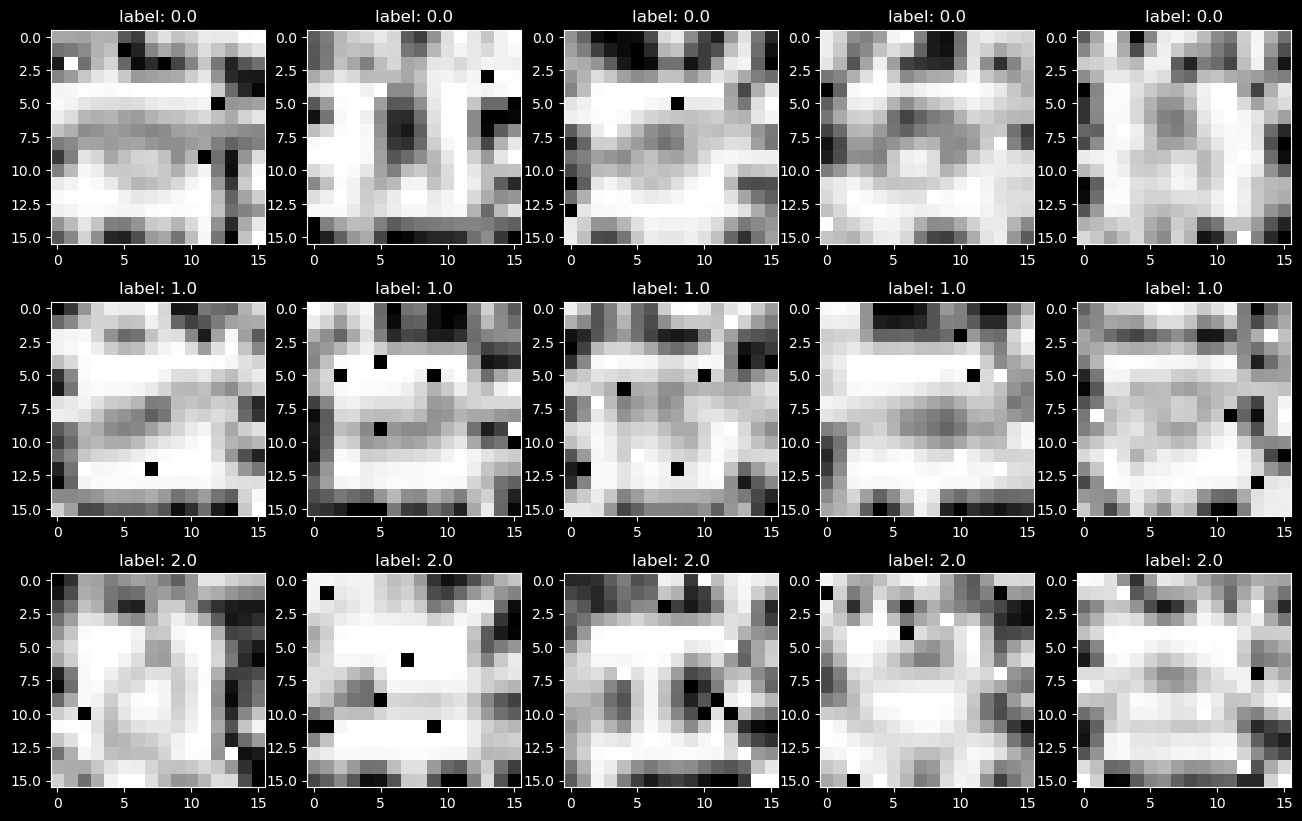

In [16]:
show_images(images, labels)

In [17]:
def show_image(img):
    plt.figure(figsize=(3,3))
    img = np.transpose(img, (1, 2, 0))
    img = np.clip(img, 0, 255)
#         img = np.nan_to_num(img, 0)
    plt.imshow(img, cmap='Grays')
    plt.show()

In [18]:
def handle_outliers(images):
    mask = np.array([[True,True,True],[True,False,True],[True,True,True]]).reshape(1,3,3)
    out_cnt = 0
    for ind, image in enumerate(images):
        # convert outlier pixels to nan
        # for loops slow, can optimize by using torch.unfold
        outliers = np.full(image.shape, False)
        image_padded = np.pad(image, ((0, 0), (1, 1), (1, 1)), constant_values=np.nan)
        for i in range(1,17):
            for j in range(1,17):
                kernel = image_padded[:, i-1:i+2, j-1:j+2][mask]
                mean = np.nanmean(kernel)
                std = np.nanstd(kernel)
                if not (mean - 3*std <= image_padded[:, i, j] <= mean + 3*std):
                    outliers[:, i-1, j-1] = True
        out_cnt += np.count_nonzero(outliers)
        image[outliers] = np.nan
        if ind % 500 == 0:
            print(ind,"done")
    out_percentage = out_cnt / np.prod(images.shape)
    print("Percentage of outliers:", out_percentage*100)
    images = handle_nans(images)
    return images

# images2 = images.copy()
images2 = handle_outliers(images.copy())

0 done
500 done
1000 done
1500 done
2000 done
2500 done
Percentage of outliers: 2.2742724236641223


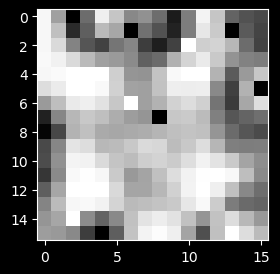

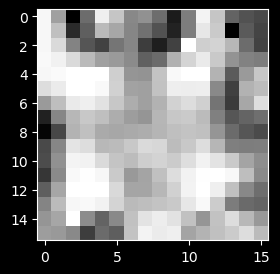

In [19]:
from random import randint
i = randint(0,len(images)-1)
show_image(images[i])
show_image(images2[i])

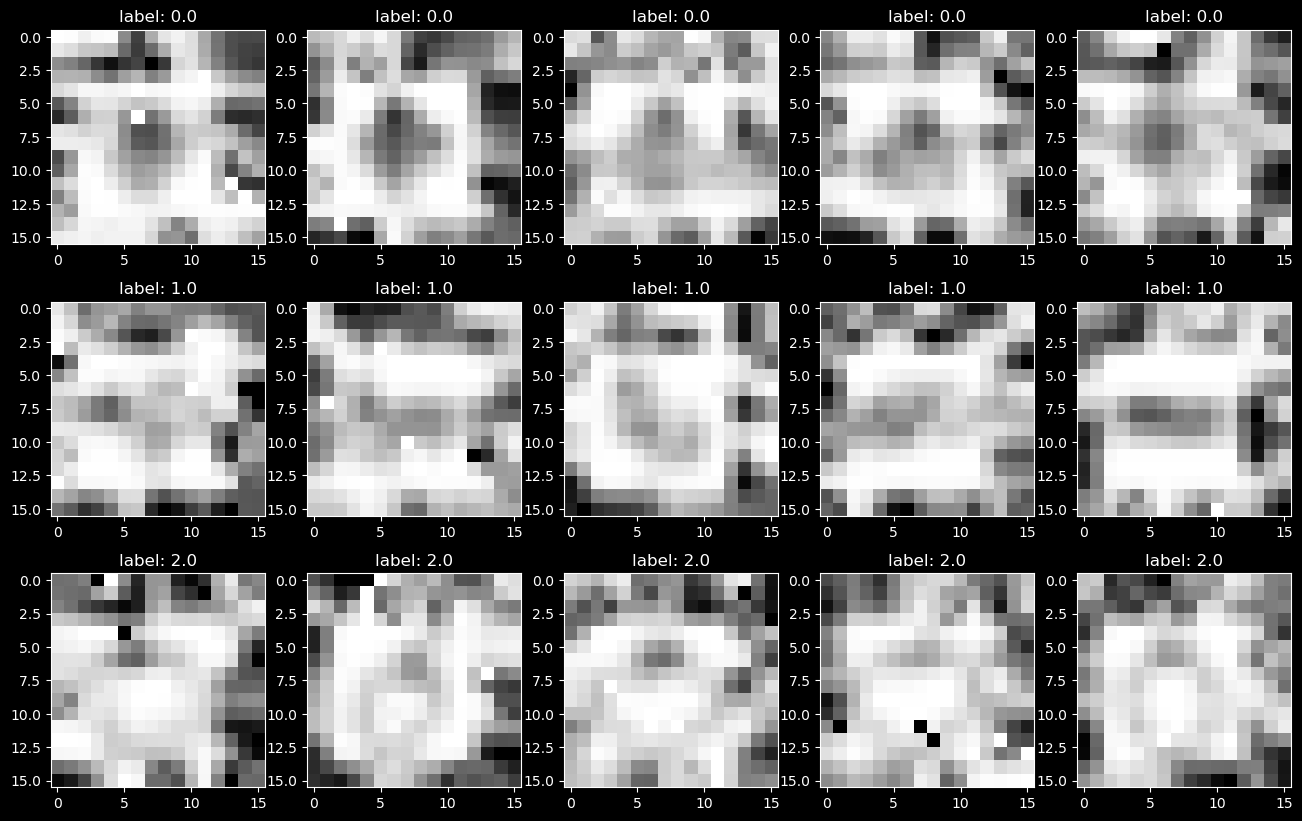

In [20]:
show_images(images2, labels)

### 4. Detection and Handling of Class Imbalance

In [21]:
images2.shape
check_imbalance(labels)

0.00    2392
1.00     203
2.00      25
Name: count, dtype: int64

In [22]:
from imblearn.under_sampling import *
from imblearn.over_sampling import *
def handle_imbalance(X, y):
    zero, one, two = np.count_nonzero(y==0), np.count_nonzero(y==1), np.count_nonzero(y==2)
    eenn = EditedNearestNeighbours(n_neighbors=3, sampling_strategy='majority')
    X, y = eenn.fit_resample(X, y)
    
#     akn = AllKNN(n_neighbors=3, sampling_strategy='majority')
#     X, y = akn.fit_resample(X, y)
    
    return X, y

### 5. Understanding Relationship Between Variables

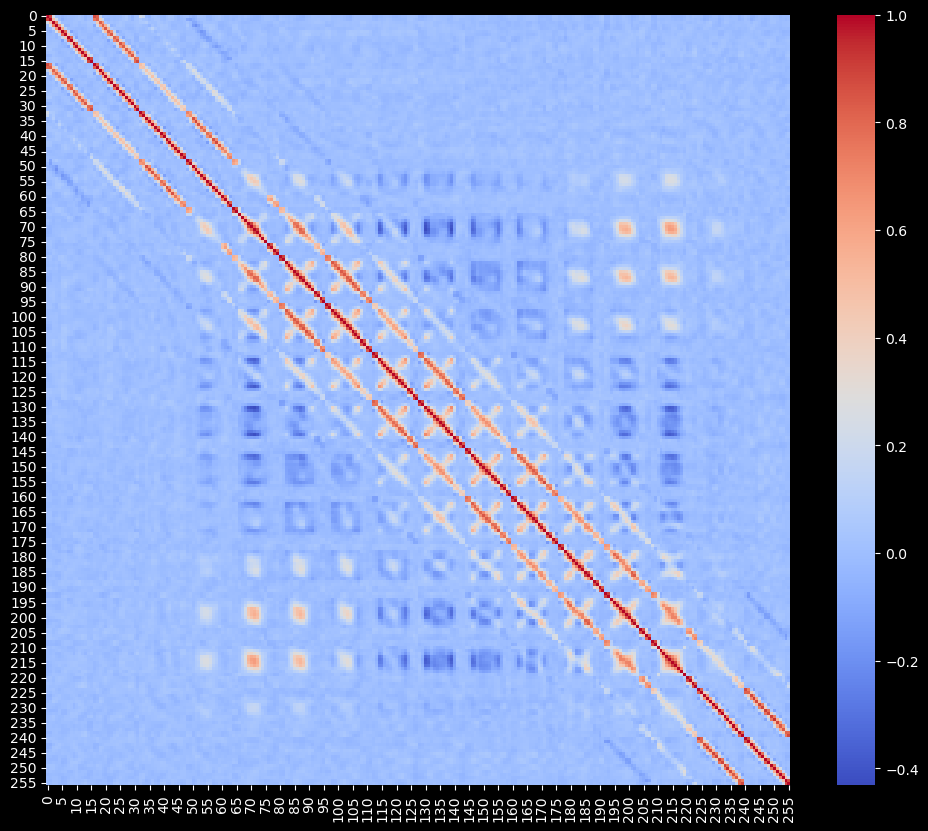

In [23]:
# calculate correlation matrix and plot it
import seaborn as sns
import matplotlib.pyplot as plt
def plot_cor(images):
    temp = images.reshape(images.shape[0], -1)
    correlation_matrix = np.corrcoef(temp, rowvar=False)
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, cmap="coolwarm")
    plt.show()
plot_cor(images2)

### 6. Data Visualization

In [24]:
pd.Series(images2.reshape(-1)).value_counts(dropna=False)

0.00      39933
255.00     6784
1.00       5352
92.00      3902
8.00       3813
          ...  
191.13        1
4.88          1
135.06        1
74.22         1
144.90        1
Name: count, Length: 3914, dtype: int64

<Figure size 1000x600 with 0 Axes>

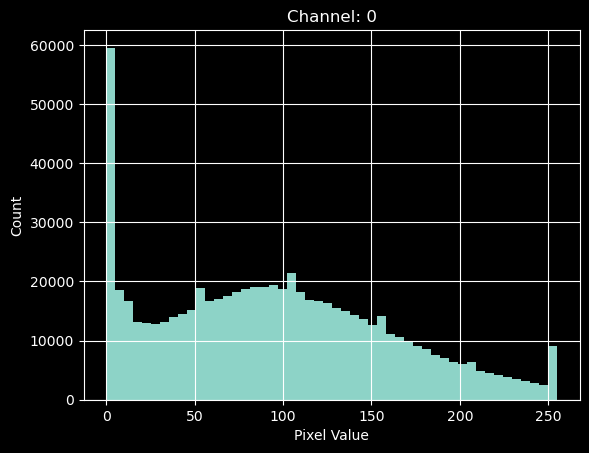

In [25]:
def plot_freq(images_t):
    # plot frequency of pixel values for each channel
    for channel in range(images_t.shape[0]):
        s = pd.DataFrame(images_t[channel])
        plt.figure(figsize=(10, 6))
        s.hist(bins=50)
        plt.title(f"Channel: {channel}")
        plt.xlabel('Pixel Value')
        plt.ylabel('Count')
        plt.show()
plot_freq(images2.transpose((1,0,2,3)).reshape(images2.shape[1],-1))

## Data Preprocessing

### 7. General Preprocessing

<Figure size 1000x600 with 0 Axes>

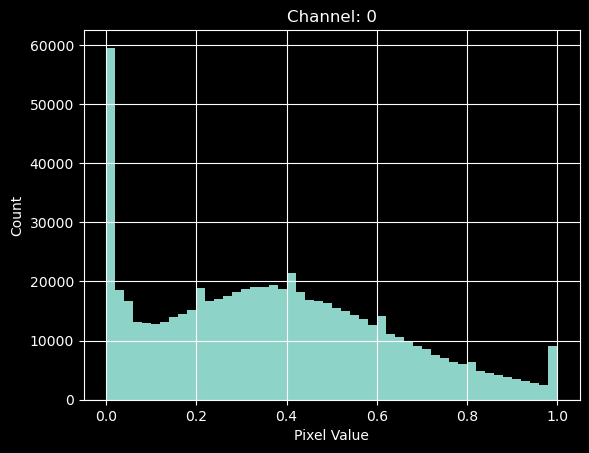

In [26]:
# normalize data
images3 = images2/255
plot_freq(images3.transpose(1,0,2,3).reshape(images3.shape[1],-1))

### 8. Feature Selection

[175]


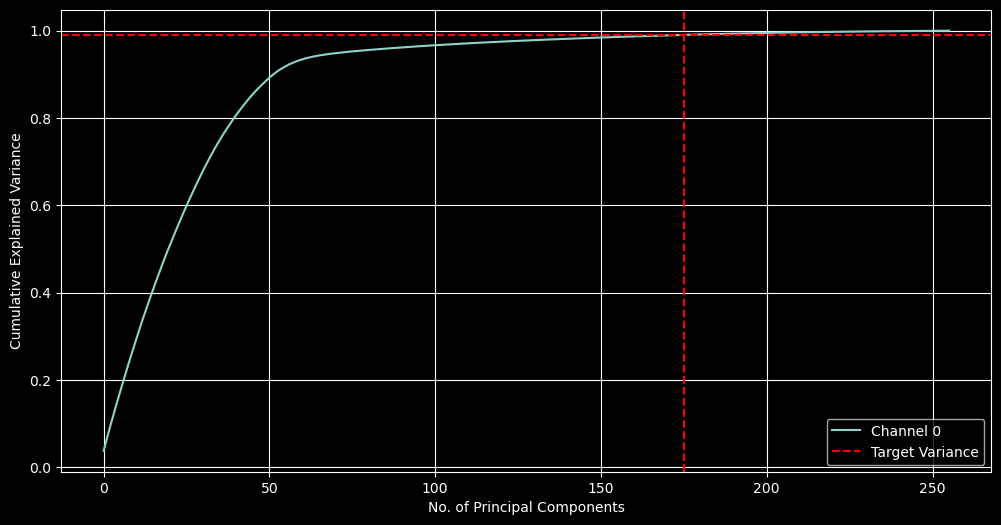

In [27]:
# perform PCA
from sklearn.decomposition import PCA

n, channels, height, width = images2.shape
flattened_images = images2.reshape((n, channels, -1))

target_variance_ratio = 0.99
n_components_per_channel = []
cumulative_variances = []

for channel in range(channels):
    pca_channel = PCA()
    pca_result = pca_channel.fit_transform(flattened_images[:, channel, :])
    cumulative_variance_ratio = np.cumsum(pca_channel.explained_variance_ratio_)
    n_components = np.argmax(cumulative_variance_ratio >= target_variance_ratio) + 1
    n_components_per_channel.append(n_components)
    cumulative_variances.append(cumulative_variance_ratio)

pca_results = []
for channel in range(channels):
    pca_channel = PCA(n_components=n_components_per_channel[channel])
    pca_result = pca_channel.fit_transform(flattened_images[:, channel, :])
    pca_results.append(pca_result)

plt.figure(figsize=(12, 6))
for channel in range(channels):
    plt.plot(cumulative_variances[channel], label=f'Channel {channel}')
plt.axhline(y=target_variance_ratio, color='r', linestyle='--', label='Target Variance')
plt.axvline(x=175, color='r', linestyle='--')

print(n_components_per_channel)

plt.xlabel('No. of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
import torch.nn as nn
# credit: https://github.com/gngdb/pytorch-pca/blob/main/pca.py
def svd_flip(u, v):
    # columns of u, rows of v
    max_abs_cols = torch.argmax(torch.abs(u), 0)
    i = torch.arange(u.shape[1]).to(u.device)
    signs = torch.sign(u[max_abs_cols, i])
    u *= signs
    v *= signs.view(-1, 1)
    return u, v

class PCA(nn.Module):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components

    @torch.no_grad()
    def fit(self, X):
        n, d = X.size()
        if self.n_components is not None:
            d = min(self.n_components, d)
        self.register_buffer("mean_", X.mean(0, keepdim=True))
        Z = X - self.mean_ # center
        U, S, Vh = torch.linalg.svd(Z, full_matrices=False)
        Vt = Vh
        U, Vt = svd_flip(U, Vt)
        self.register_buffer("components_", Vt[:d])
        return self

    def forward(self, X):
        return self.transform(X)

    def transform(self, X):
        assert hasattr(self, "components_"), "PCA must be fit before use."
        return torch.matmul(X - self.mean_, self.components_.t())

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, Y):
        assert hasattr(self, "components_"), "PCA must be fit before use."
        return torch.matmul(Y, self.components_) + self.mean_

class ImagePCA:
    def __init__(self):
        self.pca = None

    def fit_transform(self, images):
        images_transposed = images.permute(1, 0, 2, 3)
        n_c = [175, 0, 0]
        for channel in [0]:
            self.pca = PCA(n_components=n_c[channel])
            pca_result = self.pca.fit_transform(images[:, channel, :, :].reshape(-1, 16*16))
            new_channel = self.pca.inverse_transform(pca_result).reshape(-1, 16, 16)
            images_transposed[channel] = new_channel
        return images_transposed.permute(1, 0, 2, 3)

    def transform(self, images):
        images_transposed = images.permute(1, 0, 2, 3)
        for channel in [0]:
            pca_result = self.pca.transform(images[:, channel, :, :].reshape(-1, 16*16))
            new_channel = self.pca.inverse_transform(pca_result).reshape(-1, 16, 16)
            images_transposed[channel] = new_channel
        return images_transposed.permute(1, 0, 2, 3)

### 9. Feature Engineering

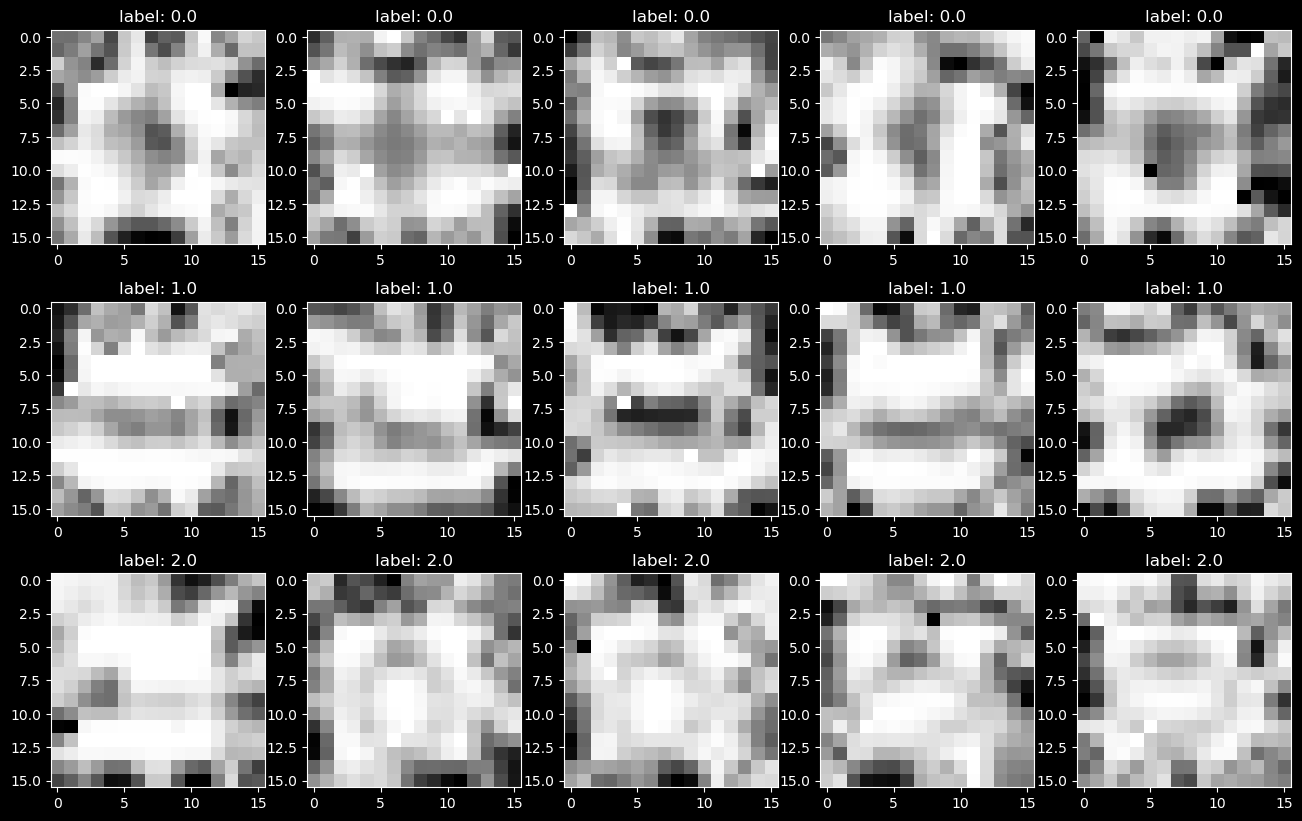

In [29]:
from torchvision import transforms as T
images_final = torch.Tensor(images3)
# images_final = T.functional.gaussian_blur(images_final, (3,3))
labels_final = torch.Tensor(labels)
show_images(images_final, labels_final.numpy())

In [30]:
images_final.shape

torch.Size([2620, 1, 16, 16])

## Modeling & Evaluation

### 10. Creating models

In [31]:
import torch
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

def get_train_test(train_size=0.9):
    X_train, X_test, y_train, y_test = train_test_split(images_final, labels_final, shuffle=True, stratify=labels_final, train_size=train_size)
    X_train = torch.Tensor(X_train).float()
    X_test = torch.Tensor(X_test).float()
    y_train = torch.Tensor(y_train).long()
    y_test = torch.Tensor(y_test).long()
    return X_train, X_test, y_train, y_test

In [32]:
import math
import torch
from torch.optim import Optimizer


class AdaBound(Optimizer):
    """Implements AdaBound algorithm.
    It has been proposed in `Adaptive Gradient Methods with Dynamic Bound of Learning Rate`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): Adam learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        final_lr (float, optional): final (SGD) learning rate (default: 0.1)
        gamma (float, optional): convergence speed of the bound functions (default: 1e-3)
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsbound (boolean, optional): whether to use the AMSBound variant of this algorithm
    .. Adaptive Gradient Methods with Dynamic Bound of Learning Rate:
        https://openreview.net/forum?id=Bkg3g2R9FX
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), final_lr=0.1, gamma=1e-3,
                 eps=1e-8, weight_decay=0, amsbound=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= final_lr:
            raise ValueError("Invalid final learning rate: {}".format(final_lr))
        if not 0.0 <= gamma < 1.0:
            raise ValueError("Invalid gamma parameter: {}".format(gamma))
        defaults = dict(lr=lr, betas=betas, final_lr=final_lr, gamma=gamma, eps=eps,
                        weight_decay=weight_decay, amsbound=amsbound)
        super(AdaBound, self).__init__(params, defaults)

        self.base_lrs = list(map(lambda group: group['lr'], self.param_groups))

    def __setstate__(self, state):
        super(AdaBound, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsbound', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group, base_lr in zip(self.param_groups, self.base_lrs):
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, please consider SparseAdam instead')
                amsbound = group['amsbound']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsbound:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsbound:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsbound:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                # Applies bounds on actual learning rate
                # lr_scheduler cannot affect final_lr, this is a workaround to apply lr decay
                final_lr = group['final_lr'] * group['lr'] / base_lr
                lower_bound = final_lr * (1 - 1 / (group['gamma'] * state['step'] + 1))
                upper_bound = final_lr * (1 + 1 / (group['gamma'] * state['step']))
                step_size = torch.full_like(denom, step_size)
                step_size.div_(denom).clamp_(lower_bound, upper_bound).mul_(exp_avg)

                p.data.add_(-step_size)

        return loss

class AdaBoundW(Optimizer):
    """Implements AdaBound algorithm with Decoupled Weight Decay (arxiv.org/abs/1711.05101)
    It has been proposed in `Adaptive Gradient Methods with Dynamic Bound of Learning Rate`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): Adam learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        final_lr (float, optional): final (SGD) learning rate (default: 0.1)
        gamma (float, optional): convergence speed of the bound functions (default: 1e-3)
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsbound (boolean, optional): whether to use the AMSBound variant of this algorithm
    .. Adaptive Gradient Methods with Dynamic Bound of Learning Rate:
        https://openreview.net/forum?id=Bkg3g2R9FX
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), final_lr=0.1, gamma=1e-3,
                 eps=1e-8, weight_decay=0, amsbound=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= final_lr:
            raise ValueError("Invalid final learning rate: {}".format(final_lr))
        if not 0.0 <= gamma < 1.0:
            raise ValueError("Invalid gamma parameter: {}".format(gamma))
        defaults = dict(lr=lr, betas=betas, final_lr=final_lr, gamma=gamma, eps=eps,
                        weight_decay=weight_decay, amsbound=amsbound)
        super(AdaBoundW, self).__init__(params, defaults)

        self.base_lrs = list(map(lambda group: group['lr'], self.param_groups))

    def __setstate__(self, state):
        super(AdaBoundW, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsbound', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group, base_lr in zip(self.param_groups, self.base_lrs):
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, please consider SparseAdam instead')
                amsbound = group['amsbound']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsbound:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsbound:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsbound:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                # Applies bounds on actual learning rate
                # lr_scheduler cannot affect final_lr, this is a workaround to apply lr decay
                final_lr = group['final_lr'] * group['lr'] / base_lr
                lower_bound = final_lr * (1 - 1 / (group['gamma'] * state['step'] + 1))
                upper_bound = final_lr * (1 + 1 / (group['gamma'] * state['step']))
                step_size = torch.full_like(denom, step_size)
                step_size.div_(denom).clamp_(lower_bound, upper_bound).mul_(exp_avg)

                if group['weight_decay'] != 0:
                    decayed_weights = torch.mul(p.data, group['weight_decay'])
                    p.data.add_(-step_size)
                    p.data.sub_(decayed_weights)
                else:
                    p.data.add_(-step_size)

        return loss

In [33]:
from sklearn.model_selection import StratifiedKFold
class StratifiedSampler(torch.utils.data.Sampler):
    def __init__(self, y, batch_size):
        n_splits = round(y.shape[0] / batch_size)
        X = np.zeros(len(y))
        sss = StratifiedKFold(n_splits=n_splits, shuffle=True)
        self.get = lambda: sss.split(X, y)
        
    def __iter__(self):
        return (test_idx for _,test_idx in self.get())

In [34]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score
from copy import deepcopy
from torchvision import transforms
from torchvision.transforms import v2

class MacroF1Loss(nn.Module):
    def __init__(self, num_classes, epsilon=1e-7):
        super().__init__()
        self.num_classes = num_classes
        self.epsilon = epsilon

    def forward(self, y_pred, y_true):
        y_true_one_hot = F.one_hot(y_true, num_classes=self.num_classes)

        tp = torch.sum(y_true_one_hot * y_pred, dim=0)
        fp = torch.sum((1 - y_true_one_hot) * y_pred, dim=0)
        fn = torch.sum(y_true_one_hot * (1 - y_pred), dim=0)
    
        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)
    
        f1 = 2 * precision * recall / (precision + recall + self.epsilon)
        return 1 - torch.mean(f1) # minimize loss so put 1-

In [35]:
from datetime import datetime
from IPython.display import clear_output

def plot_loss(train_loss=None, val_loss=None, eval_loss=None, train_f1=None, val_f1=None, eval_f1=None, lr=None, last=False, clear=True):
    epochs = range(1,len(train_loss)+1)
    fig = plt.figure(figsize=(10,6), dpi=200)
    plt.plot(epochs, train_loss, marker='x', label='Training Loss')
    if val_loss:
        plt.plot(epochs, val_loss, marker='^', label='Validation Loss')
    if eval_loss:
        plt.plot(epochs, eval_loss, marker='s', label='Evaluation Loss')
    if train_f1:
        plt.plot(epochs, train_f1, marker='x', label='Training F1')
    if val_f1:
        plt.plot(epochs, val_f1, marker='^', label='Validation F1')
    if eval_f1:
        plt.plot(epochs, eval_f1, marker='s', label='Evaluation F1')
    if lr:
        plt.title(f'lr = {lr:.6f}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss / F1')
    plt.legend()
    plt.grid(True)
    plt.xlim(0, len(epochs))
    plt.ylim(0, 1)
    if clear:
        clear_output(wait=True)
    plt.show()
    if last:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S%f")[:-3]
        save_path = f'{timestamp}.png'
        fig.savefig(save_path)
    
def train(model, train_dataloader, val_set=None, eval_set=None, n_epochs=150, early_stopping=True, cpu=False):
    if early_stopping:
        assert val_set is not None
    
    train_set = [train_dataloader.dataset.X, train_dataloader.dataset.y]
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if cpu: device = 'cpu'
    model.to(device)
    
    if val_set:
        X_val, y_val_true = val_set
        X_val = X_val.to(device)
        y_val_true = y_val_true.to(device)
    if eval_set:
        X_eval, y_eval_true = eval_set
        X_eval = X_eval.to(device)
        y_eval_true = y_eval_true.to(device)

#     criterion = MacroF1Loss(3)
#     weights = torch.Tensor([1/1000,1/150,1/20]).to(device)
#     criterion = CrossEntropyLoss(weight=weights)
    criterion = CrossEntropyLoss()
    
#     optimizer = optim.Adam(model.parameters(), amsgrad=True, weight_decay=0.0e-4)
#     optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=5e-4)
    optimizer = AdaBound(model.parameters(), lr=0.005, amsbound=True, weight_decay=0.0e-5)
#     optimizer = AdaBoundW(model.parameters(), lr=0.01, weight_decay=5e-5, amsbound=True)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=1.0)
    
    best_val_f1 = 0.0
    best_epoch = None
    best_model_state = None
    train_losses = []
    val_losses = []
    eval_losses = []
    train_f1 = []
    val_f1 = []
    eval_f1 = []
    
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            # collect garbage every 100 epochs
            gc.collect()
        model.train()
        train_loss = 0.0
        n = 0
        curr_lr = scheduler.get_last_lr()[0]
        for X_train, y_train in train_dataloader:
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            optimizer.zero_grad()
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            train_loss += loss.item()
            n += 1
            loss.backward()
            optimizer.step()
        scheduler.step()
        
        train_loss /= n
        train_losses.append(train_loss)
        
        model.eval()
        train_f1.append(evaluate(model, train_set)[0])

        if val_set:
            with torch.no_grad():
                y_pred = model(X_val)
                val_loss = criterion(y_pred, y_val_true).item()
                val_losses.append(val_loss)
            
            val_f1.append(evaluate(model, val_set)[0])
            if val_f1[-1] >= best_val_f1:
                best_val_f1 = val_f1[-1]
                best_epoch = epoch
                if early_stopping:
                    best_model_state = deepcopy(model.state_dict())

        if eval_set:
            with torch.no_grad():
                y_pred = model(X_eval)
                eval_loss = criterion(y_pred, y_eval_true).item()
                eval_losses.append(eval_loss)
            eval_f1.append(evaluate(model, eval_set)[0])
        
        plot_loss(train_losses, val_losses, eval_losses, train_f1, val_f1, eval_f1, lr=curr_lr, last=epoch==n_epochs-1)

    print(f"best_val_f1: {best_val_f1:.2f}, best_epoch: {best_epoch}")
    if early_stopping:
        model.load_state_dict(best_model_state)
    return best_val_f1

def evaluate(model, val_set, return_val=False):
    X, y_true = val_set
    model.to(device)
    model.eval()
    with torch.no_grad():
        y_proba = model(X.to(device))

    y_pred = torch.argmax(y_proba, dim=1).cpu()
    y_true = y_true.cpu()
    f1 = f1_score(y_true, y_pred, average='macro')
    pr = precision_score(y_true, y_pred, average='macro')
    rc = recall_score(y_true, y_pred, average='macro')

    if return_val:
        return y_true, y_pred
    return f1, pr, rc

class CustomTensorDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __getitem__(self, index):
        x = self.X[index]
        if self.transform:
            x = self.transform(x)
        return x, self.y[index]

    def __len__(self):
        return self.X.size(0)

def get_dataloaders(X_train, X_test, y_train, y_test, batch_size=64, apply_pca=True, apply_bal=True):
    if apply_pca:
        pca = ImagePCA()
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
    
    if apply_bal:
        print(check_imbalance(y_train))
        X_train, y_train = handle_imbalance(X_train.reshape(-1,16*16), y_train)
        X_train = X_train.reshape(-1,1,16,16)
        print(check_imbalance(y_train))
        X_train = torch.Tensor(X_train).float()
        y_train = torch.Tensor(y_train).long()
    
#     X_train = X_train.to(device)
#     X_test = X_test.to(device)
#     y_train = y_train.to(device)
#     y_test = y_test.to(device)
    
    T = v2
    p = 1/6
    trans = T.Compose([
        T.RandomApply([lambda tensor: torch.flip(tensor, dims=[1])], p=p), # flip up-down
        T.RandomChoice([lambda tensor: tensor,                               # dont rotate
                        lambda tensor: torch.rot90(tensor, k=1, dims=[1,2]), # rotate 90
                        lambda tensor: torch.rot90(tensor, k=2, dims=[1,2]), # rotate 180
                        lambda tensor: torch.rot90(tensor, k=3, dims=[1,2]), # rotate 270
        ], p=[3/p-3,1,1,1]),
#         T.RandomApply([lambda tensor: T.functional.gaussian_blur(tensor, (3,3))], p=p)
    ])
    
    # OFFLINE AUGMENTATION
#     print("Before aug:", X_train.shape)
#     X_train = torch.cat([X_train, 
#                          torch.rot90(X_train, k=1, dims=[2,3]), 
#                          torch.rot90(X_train, k=2, dims=[2,3]),
#                          torch.rot90(X_train, k=3, dims=[2,3]),
#                          torch.flip(X_train, dims=[2]),
#                          torch.flip(X_train, dims=[3])
#                         ])
#     y_train = torch.cat([y_train] * 6)
#     print("After aug:", X_train.shape)
    
    train_dataset = CustomTensorDataset(X_train, y_train, transform=trans)
    sampler = StratifiedSampler(y_train, batch_size)
    return (
        DataLoader(train_dataset, batch_sampler=sampler),
#         DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
        [X_test, y_test],
    )

def train_validate(model_class, n_epochs=150, early_stopping=False, n_folds=10, random_state=None):
    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    metrics = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
        train_dataloader, val_set = get_dataloaders(X_train[train_idx], X_train[val_idx], y_train[train_idx], y_train[val_idx])
        model = model_class()
        best_val_f1 = train(model, train_dataloader, val_set, n_epochs=n_epochs, early_stopping=early_stopping)
        f1, pr, rc = evaluate(model, val_set)
        metrics.append((f1, pr, rc))
        open("out.txt",'a').write(f"Fold {fold + 1}/{n_folds}, best_val_f1: {best_val_f1:.3f}\n")
        open("out.txt",'a').write(f"{f1:.3f} {pr:.3f} {rc:.3f}\n")

    final_scores = tuple(np.sum(metrics, axis=0) / len(metrics))
    f1, pr, rc = final_scores
    open("out.txt",'a').write(f"Overall: {f1:.3f} {pr:.3f} {rc:.3f}\n")
    return final_scores

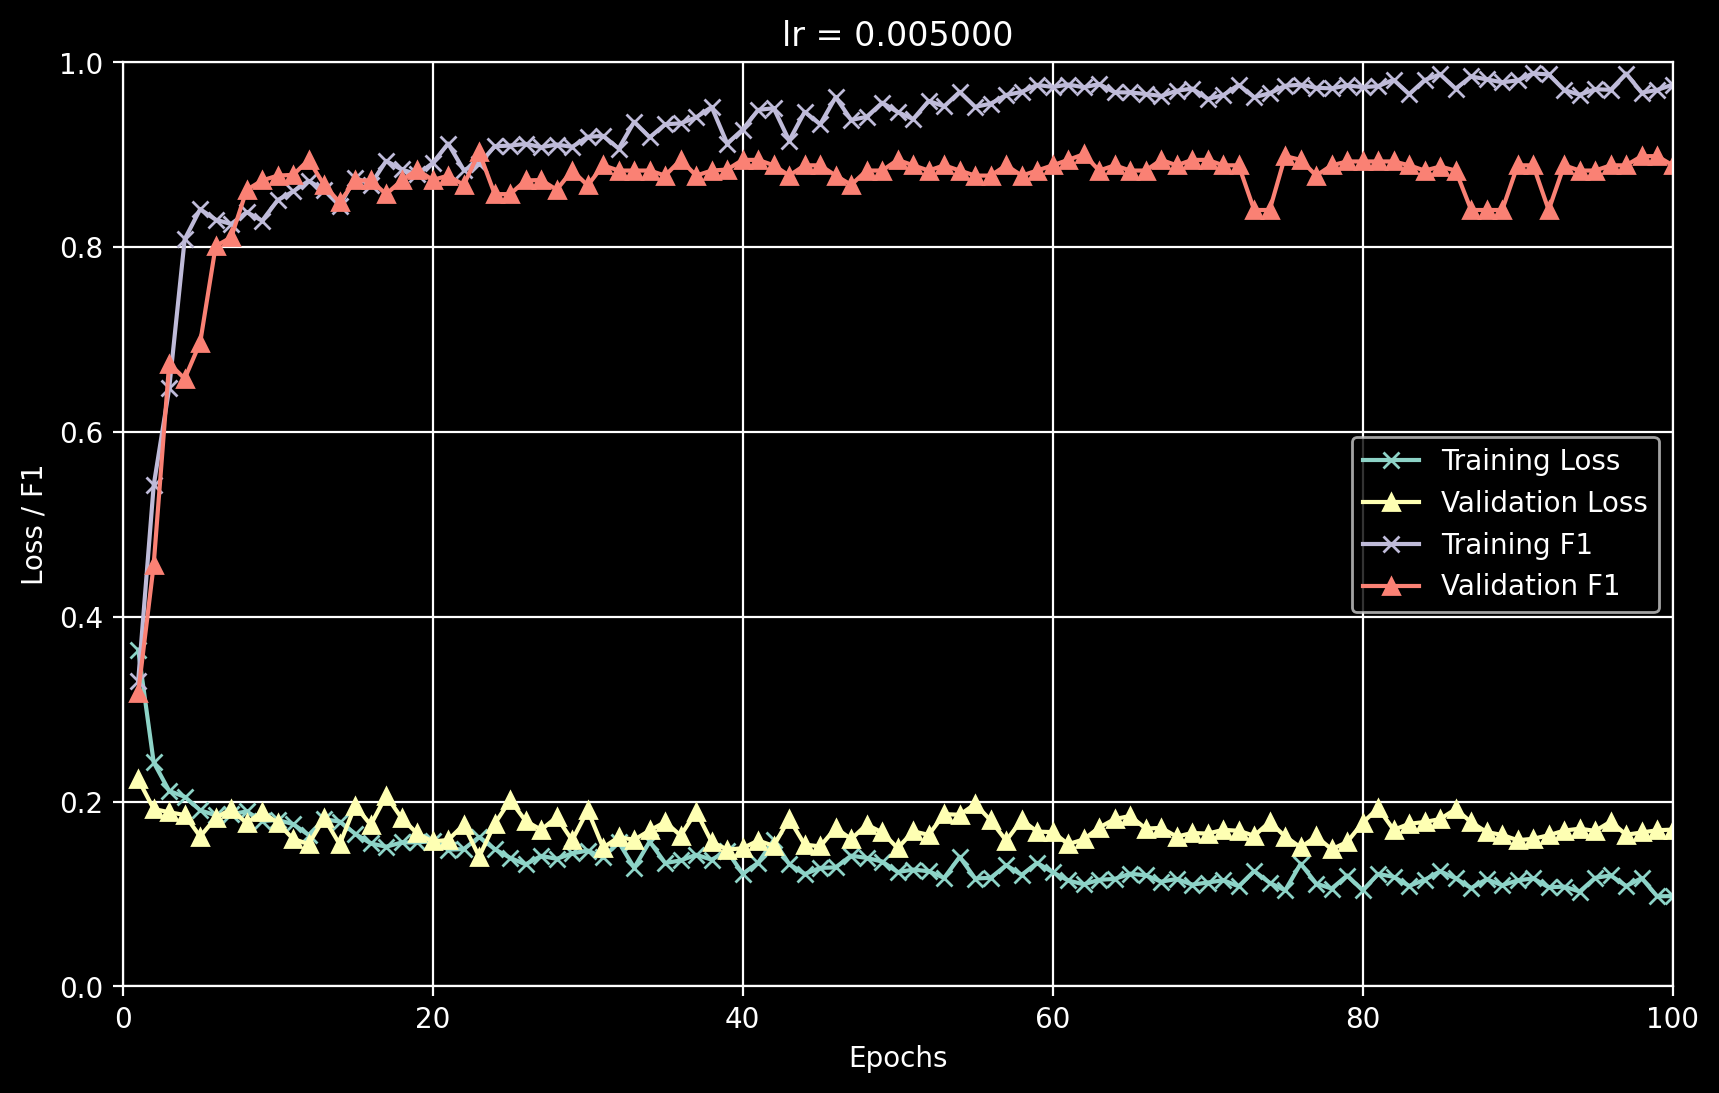

best_val_f1: 0.90, best_epoch: 22


AssertionError: 

In [36]:
import random
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

class CNN(nn.Module):
    def __init__(self, in_channels=1, out_channels=3):
        super().__init__()
        p = 1/4
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 8, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=p),
            
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(p=p),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(p=p),
            
            nn.Flatten()
        )
        self.fc = nn.Sequential(
#             nn.Linear(128, 128),
#             nn.ReLU(),
#             nn.BatchNorm1d(128),
#             nn.Dropout(p=p),

            nn.Linear(128, out_channels),
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
#         x = nn.Softmax(dim=1)(x)
        return x

# seed = np.random.randint(0, 2**31-1)
# # set_seed(seed)

# X_train, X_test, y_train, y_test = get_train_test()

best_model_class = None
X_train = torch.Tensor(images_final).float()
y_train = torch.Tensor(labels_final).long()
for model_class in [CNN]:
    f1, pr, rc = train_validate(model_class, n_epochs=100, random_state=None)
assert 0

In [ ]:
import torchvision
gc.collect()
from sklearn.metrics import *

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

l = []
for i in range(10):
    model = CNN(images_final.shape[1], 3)
    print(count_parameters(model))
    
    X_train, X_test, y_train, y_test = get_train_test(train_size=0.9)
    use_eval = False
    if use_eval:
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, train_size=0.72)
        train_dataloader, val_set = get_dataloaders(X_train, X_val, y_train, y_val)
        eval_set = [X_test, y_test]
    else:
        train_dataloader, val_set = get_dataloaders(X_train, X_test, y_train, y_test)
        eval_set = val_set
        
#     assert 0
    
    best_val_f1 = train(model, train_dataloader, val_set=val_set, eval_set=None, n_epochs=100, early_stopping=False, cpu=False)
    y_true, y_pred = evaluate(model, eval_set, return_val=True)
    f1 = f1_score(y_true, y_pred, average='macro')
    pr = precision_score(y_true, y_pred, average='macro')
    rc = recall_score(y_true, y_pred, average='macro')
    open("out.txt",'a').write(f"{f1:.3f}, {pr:.3f}, {rc:.3f}\n")
    l.append(f1)
avg = np.mean(l)
open("out.txt",'a').write(f"{avg:.3f}\n")

In [ ]:
# # train and evaluate (the actual "right" way except datastet is too small, so result is very random)
# train_dataloader, eval_set = get_dataloaders(X_train, X_test, y_train, y_test)
# model = CNN()
# train(model, train_dataloader, val_set=None, eval_set=eval_set, n_epochs=100, early_stopping=False, cpu=False)

# y_true, y_pred = evaluate(model, eval_set, return_val=True)
# f1 = f1_score(y_true, y_pred, average='macro')
# pr = precision_score(y_true, y_pred, average='macro')
# rc = recall_score(y_true, y_pred, average='macro')
# print(f1, pr, rc)

In [ ]:
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()